# Milestone 3 - Fictional worlds analysis
...

In [165]:
import os
from tqdm import tqdm

# array and dataframes
import pandas as pd
import numpy as np 

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# natural language processing
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
import spacy

# topic modelling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV

from gensim.models import CoherenceModel
from gensim.corpora import Dictionary

#nlp = spacy.load("en_core_web_sm")
nlp = spacy.load("en_core_web_md")

# Import extra functions and datasets

In [2]:
import preprocessing
import topic_modeling

In [3]:
folder_path = os.path.abspath('MovieSummaries')
df_movies, df_summaries = preprocessing.get_datasets(folderpath=folder_path)

In [4]:
df_genres = preprocessing.get_movie_genres_dataframe(df_movies=df_movies)
df_fictional_summaries, df_fictional = preprocessing.get_fictional_summaries_subset(df_genres=df_genres, df_movies=df_movies, df_summaries=df_summaries, return_df_fictional=True)
# takes around 20s

   Wikipedia_movie_ID Freebase_genre_ID      movie_genre
0              975900         /m/01jfsb         Thriller
1              975900          /m/06n90  Science Fiction
2              975900          /m/03npn           Horror
3              975900         /m/03k9fj        Adventure
4              975900          /m/0fdjb     Supernatural
The total number of movies referred to as fictional is 5366, corresponding to 6.56% of whole movies.


In [6]:
imdb_title_genre_df = pd.read_table("Dataset/IMDB/title.basics.tsv/data.tsv", delimiter='\t')
# takes 30s

C:\Users\gezas\AppData\Local\Temp\ipykernel_4960\949645751.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  imdb_title_genre_df = pd.read_table("Dataset/IMDB/title.basics.tsv/data.tsv", delimiter='\t')


# Getting the subset of movies with genre "science-fiction" or "fantasy"
This approach is based on CMU genres combined with IMDB genre metadata

In [7]:
# remove movies without genre given
df_imdb_movie_genred = imdb_title_genre_df[~imdb_title_genre_df['genres'].isna()]
# Select rows where "Sci-Fi" or "Fantasy" appear in genres
df_imdb_fictional = df_imdb_movie_genred[df_imdb_movie_genred['genres'].str.contains('Sci-Fi|Fantasy', case=False, regex=True)]
# The full dataset from imdb
df_imdb_fictional.shape # row N = 312105

(312105, 9)

In [9]:
# Get all CMU movies which are fictional based IMDB dataset genres by merging on their name
df_fictional_cmu_imdb = pd.merge(df_movies,
                              df_imdb_fictional[[ 'tconst', 'titleType', 'isAdult', 'primaryTitle', 'originalTitle', 'startYear', 'genres']],
                              left_on='movie_name', right_on='primaryTitle', how='inner', suffixes = ['CMU', 'IMDB'])
# Get summaries from movies that are genred as fictional in IMDB
df_fictional_summaries_idmb = df_summaries[df_summaries['Wikipedia_movie_ID'].isin(df_fictional_cmu_imdb['Wikipedia_movie_ID'])]

In [10]:
# Merging the result to have metadata information related to each summary

#movie_metadata_of_interest = ['Wikipedia_movie_ID', 'Freebase_movie_ID', 'movie_name', 'movie_release_date', 'movie_box_office_revenu', 'movie_runtime', 'movie_genres', 'tconst', 'titleType', 'isAdult', 'primaryTitle', 'originalTitle', 'startYear', 'genres']
movie_metadata_of_interest = ['Wikipedia_movie_ID','movie_name','movie_release_date', 'movie_box_office_revenu', 'movie_runtime']

# Merge with movies to have more information related to each summary
df_fictional = pd.merge(df_fictional_summaries, df_movies[movie_metadata_of_interest], on='Wikipedia_movie_ID')
df_fictional_idmb = pd.merge(df_fictional_summaries_idmb, df_movies[movie_metadata_of_interest], on='Wikipedia_movie_ID')

# Find year based on cmu release date info (could be found also with imdb)
df_fictional['release_year'] = pd.to_datetime(df_fictional['movie_release_date'], format='mixed', errors='coerce').dt.year
df_fictional_idmb['release_year'] = pd.to_datetime(df_fictional_idmb['movie_release_date'], format='mixed', errors='coerce').dt.year

In [11]:
# Merge all summaries that have at least be found to be referenced as science fiction or fantasy in one of the datasets
df_fictional_summaries_all = pd.concat((df_fictional, df_fictional_idmb)).drop_duplicates('Wikipedia_movie_ID', keep='first')
print(df_fictional_summaries_all.shape) #(10871, 7)

(10871, 7)


In [12]:
df_fictional_summaries_all.head()

,Wikipedia_movie_ID,movie_summary,movie_name,movie_release_date,movie_box_office_revenu,movie_runtime,release_year
0,31186339,The nation of Panem consists of a wealthy Capi...,The Hunger Games,2012-03-12,686533290.0,142.0,2012.0
1,1838882,"The evil Lord Conqueror, head of Conqueror's C...",The Storm Riders,1998,NaN,130.0,1998.0
2,4466226,During the Great depression in 1933 in Winnipe...,The Saddest Music in the World,2003-09-07,NaN,100.0,2003.0
3,657446,"In Los Angeles, California Fletcher Reede is ...",Liar Liar,1997-03-21,302710615.0,86.0,1997.0
4,32163620,"In the winter of 1945, immediately after the l...",Gates of the Night,1946-12-03,NaN,120.0,1946.0


# Visually exploring the subset of summaries

Text(0.5, 1.0, 'Count of movie summaries classified as fictional per year')

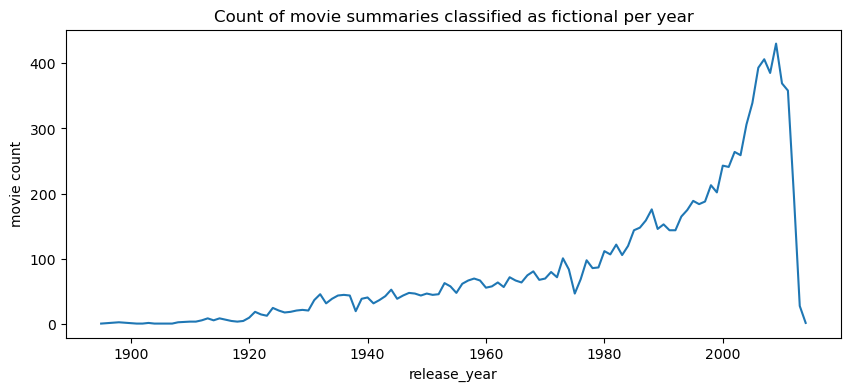

In [13]:
plt.figure(figsize=(10,4))
sns.lineplot(df_fictional_summaries_all.groupby('release_year')['Wikipedia_movie_ID'].agg("count"))
plt.ylabel('movie count')
plt.title('Count of movie summaries classified as fictional per year')

# Topic Modelling

In [8]:
from tqdm import tqdm

# natural language processing
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
import spacy

# topic modelling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import LatentDirichletAllocation

#nlp = spacy.load("en_core_web_sm")
nlp = spacy.load("en_core_web_md")

## i) Preprocess the summaries
Preprocessing the summaries involves, via tokenization, removing stop words and proper noun and taking only the lemma of each word.

In [109]:
def preprocess_docs(docs, nlp=nlp, batch_size=100, n_process=-1, entities_to_include = ['EVENT', 'DATE']):
    result_array = []
    for doc in tqdm(nlp.pipe(docs, disable=["parser", "textcat"], batch_size=batch_size, n_process=n_process)):
        tokens = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop and token.pos_ not in ['PROPN']]

        # Iterate through named entities in the document
        for ent in doc.ents:
            if ent.label_ in entities_to_include:
                element = ent.text.lower()
                if element not in tokens:
                    tokens.append(element)

        result_array.append(" ".join(tokens))
    return result_array

In [111]:
docs = df_fictional_summaries_all['movie_summary']
result_array = preprocess_docs(docs)
# takes around 3min

10867it [03:39, 49.57it/s] 


In [112]:
df_fictional_summaries_all['preprocessed_summary'] = result_array
df_fictional_summaries_all.head()

,Unnamed: 0,Wikipedia_movie_ID,movie_summary,movie_name,movie_release_date,movie_box_office_revenu,movie_runtime,release_year,preprocessed_summary,wordcount_min10freq,period,release_decade,wordcount_min5freq
0,0,31186339,The nation of Panem consists of a wealthy Capi...,The Hunger Games,2012-03-12,686533290.0,142.0,2012.0,nation consist wealthy poor district punishmen...,295,after 2010s,2010.0,296
1,1,1838882,"The evil Lord Conqueror, head of Conqueror's C...",The Storm Riders,1998,NaN,130.0,1998.0,evil head give prophecy say find young child g...,117,90s,1990.0,118
2,2,4466226,During the Great depression in 1933 in Winnipe...,The Saddest Music in the World,2003-09-07,NaN,100.0,2003.0,great depression old fortune teller predict fu...,255,2000-2005,2000.0,262
3,3,657446,"In Los Angeles, California Fletcher Reede is ...",Liar Liar,1997-03-21,302710615.0,86.0,1997.0,career focus lawyer divorced father love spend...,245,90s,1990.0,247
4,4,32163620,"In the winter of 1945, immediately after the l...",Gates of the Night,1946-12-03,NaN,120.0,1946.0,winter immediately liberation member french un...,46,before 1950,1940.0,46


In [113]:
#Preprocessing lead to some empty summaries
df_nan= df_fictional_summaries_all["preprocessed_summary"].isna()
df_empty = (df_fictional_summaries_all['preprocessed_summary'] == '')
df_fictional_summaries_all[df_nan | df_empty]

,Unnamed: 0,Wikipedia_movie_ID,movie_summary,movie_name,movie_release_date,movie_box_office_revenu,movie_runtime,release_year,preprocessed_summary,wordcount_min10freq,period,release_decade,wordcount_min5freq


In [114]:
# Empty preprocessed summaries removal
df_fictional_summaries_all = df_fictional_summaries_all.drop(df_fictional_summaries_all[df_nan | df_empty].index)
df_fictional_summaries_all.shape

(10867, 13)

In [115]:
vectorizer5 = CountVectorizer(min_df=5)
dtm5 = vectorizer5.fit_transform(df_fictional_summaries_all['preprocessed_summary'])
df_fictional_summaries_all['wordcount_min5freq'] = np.sum(dtm5, axis = 1) #number of word in the preprocessed summaries for each movie

In [116]:
df_fictional_summaries_all

,Unnamed: 0,Wikipedia_movie_ID,movie_summary,movie_name,movie_release_date,movie_box_office_revenu,movie_runtime,release_year,preprocessed_summary,wordcount_min10freq,period,release_decade,wordcount_min5freq
0,0,31186339,The nation of Panem consists of a wealthy Capi...,The Hunger Games,2012-03-12,686533290.0,142.0,2012.0,nation consist wealthy poor district punishmen...,295,after 2010s,2010.0,312
1,1,1838882,"The evil Lord Conqueror, head of Conqueror's C...",The Storm Riders,1998,NaN,130.0,1998.0,evil head give prophecy say find young child g...,117,90s,1990.0,125
2,2,4466226,During the Great depression in 1933 in Winnipe...,The Saddest Music in the World,2003-09-07,NaN,100.0,2003.0,great depression old fortune teller predict fu...,255,2000-2005,2000.0,266
3,3,657446,"In Los Angeles, California Fletcher Reede is ...",Liar Liar,1997-03-21,302710615.0,86.0,1997.0,career focus lawyer divorced father love spend...,245,90s,1990.0,250
4,4,32163620,"In the winter of 1945, immediately after the l...",Gates of the Night,1946-12-03,NaN,120.0,1946.0,winter immediately liberation member french un...,46,before 1950,1940.0,53
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10862,9551,24211707,The film follows a United States Border Patrol...,Borderline,1980-10-31,NaN,99.0,1980.0,film follow force track killer young mexican b...,586,70s,1980.0,607
10863,9555,13348400,Jennie Lee is the lead singer of an all-girl ...,Satisfaction,1988-02-12,8253123.0,92.0,1988.0,lead singer girl rock band name high school gr...,287,80s,1980.0,292
10864,9556,277160,"Virginia ""Gin"" Baker is an investigator for W...",Entrapment,1999-04-30,212404396.0,113.0,1999.0,investigator international art thief priceless...,162,90s,1990.0,165
10865,9558,17736697,Paula Eastman is a Hollywood actress with an ...,Torch Song,1993-05-23,NaN,89.0,1993.0,actress alcohol problem career poorly sleep ac...,55,90s,1990.0,55


<Axes: xlabel='release_year', ylabel='wordcount_min5freq'>

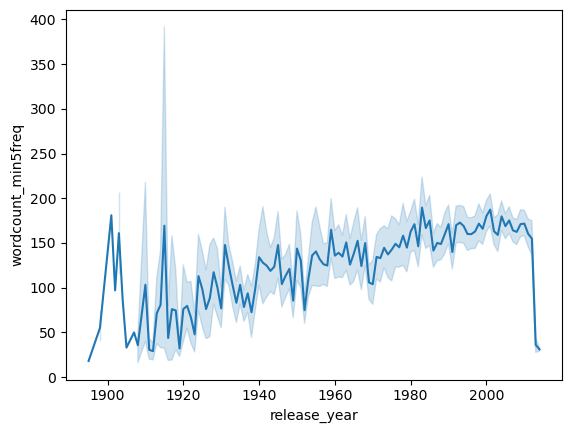

In [117]:
plt.figure()
sns.lineplot(data=df_fictional_summaries_all.reset_index() , x = 'release_year', y = 'wordcount_min5freq')

After 1950, the mean number of words in the preprocessed summaries is more stable with a slight increase and variation of around 30 words. 
This is a good news because it means that if by performing a topic modelling on each decades after 1950, the results wont be biaised by the number of words per summaries. 

In [118]:
df_fictional_summaries_all['period'] = pd.cut(df_fictional_summaries_all.release_year, bins=[0, 1950, 1960, 1970, 1980, 1990, 2000, 2005, 2010, 2023], labels=['before 1950', '50s', '60s', '70s', '80s', '90s', '2000-2005', '2005-2010', ' after 2010s'])

Text(0.5, 0, 'summary count')

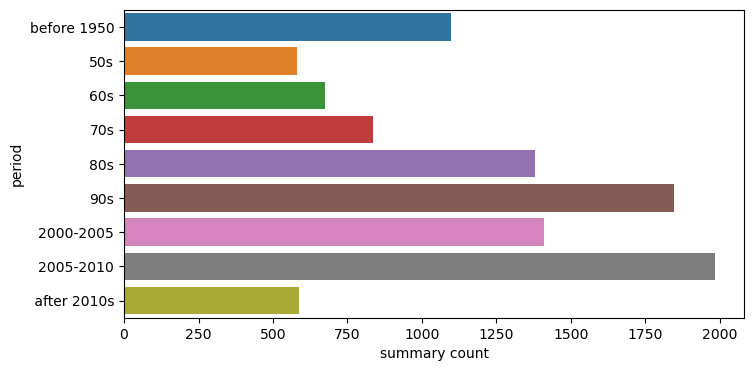

In [119]:
plt.figure(figsize=(8,4))
sns.countplot(data=df_fictional_summaries_all, y='period')
plt.xlabel('summary count')

Text(0.5, 0, 'feature (tokens) count per summary')

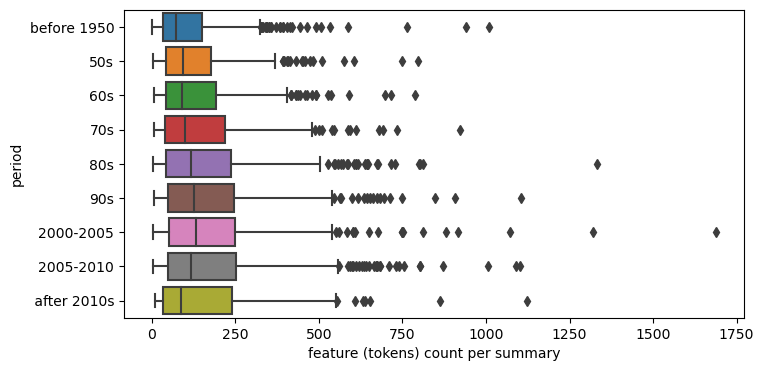

In [120]:
# plot token counts
plt.figure(figsize=(8,4))
sns.boxplot(data = df_fictional_summaries_all, x = 'wordcount_min10freq', orient='h', y = 'period')
plt.xlabel('feature (tokens) count per summary')

In [121]:
file = os.path.abspath('df_summaries_preprocessed_all.csv')
task = 'save' # 'read', 'save

if task =='save':
    df_fictional_summaries_all.to_csv(file)
    print(f'saved df to {file}')
    
elif task=='read':
    df_fictional_summaries_all = pd.read_csv(file)
    print(f"Loaded dataframe from {file}")

saved df to d:\gezas\Documents\EPFL-MA-W\ADA\ada-2023-project-thepiratesofthestreet\df_summaries_preprocessed_all.csv


## ii) LDA topic modelling overall

In [122]:



# Define function to show top n keywords for each topic
def show_topics(vectorizer, lda_model, n_words=10):
    keywords = np.array(vectorizer.get_feature_names_out())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

def plot_top_words(model, feature_names, n_top_words, n_topics, title):
    """
    Function to plot n top words for m topics as horizontals barplots with the measured weight.
    
    This function is taken and adapted from sklearn example at https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html
    """
    # Get number of rows and columns to plot
    row_n = np.ceil(n_topics/5).astype(int)
    col_n = min([n_topics, 5])
    h_per_topic = n_top_words*0.25
    
    # Main figure with row_n x col_n subplots 
    fig, axes = plt.subplots(row_n, col_n, figsize=(12, h_per_topic*row_n+2), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        # getting words and their weight from topics
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        # plot results as horizontal bars
        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.5)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 20})
        ax.tick_params(axis="both", which="major", labelsize=15)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=20)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.tight_layout()
    plt.show()
    
def plot_grid_search_score(grid_search):
    # Extract relevant information from cv_results_
    mean_test_scores = grid_search.cv_results_['mean_test_score']
    params = grid_search.cv_results_['params']

    # Extract hyperparameter values for plotting
    alpha_values = [param['doc_topic_prior'] for param in params]
    beta_values = [param['topic_word_prior'] for param in params]

    # Create a 2D plot
    plt.figure(figsize=(6, 5))

    # Scatter plot with color representing mean test scores
    sc = plt.scatter(alpha_values, beta_values, c=mean_test_scores, cmap='viridis', s=100, edgecolors='k', alpha=0.7)

    # Colorbar
    plt.colorbar(sc, label='Mean Test Score (Negative Log-Likelihood)')

    # Set labels and title
    plt.xlabel('Doc Topic Prior (alpha)')
    plt.ylabel('Topic Word Prior (beta)')
    plt.title('Grid Search Results')

    # Show the plot
    plt.show()

In [150]:
docs = df_fictional_summaries_all[df_fictional_summaries_all.period=='before 1950']['preprocessed_summary']

# Some parameter to fit
n_features = None

# Vectorize the summaries
vectorizer = CountVectorizer(max_df = 0.75, min_df=5, ngram_range=(1,3), max_features=n_features)
vectorizer_tfidf = TfidfVectorizer(max_df = 0.75, min_df=5, use_idf=True, ngram_range=(1,3), max_features=n_features, norm='l1')

dtm = vectorizer.fit_transform(docs)
# normalize per row
transformer = Normalizer(norm='l1').fit(dtm)
dtm = transformer.transform(dtm)

dtm_idf = vectorizer_tfidf.fit_transform(docs)

dtm.shape, dtm_idf.shape

((1098, 4011), (1098, 4011))

In [161]:
tf_feature_names = vectorizer.get_feature_names_out()

In [159]:
def plot_tf_weights(dtm, feature_names, row_index, N = 30):
    """
    Plot the words along with their TF-IDF weights for a specific row in a TF-IDF matrix.

    Parameters:
    - dtm_idf: TF-IDF matrix (scipy.sparse.csr_matrix)
    - feature_names: List of feature names (words)
    - row_index: Index of the row to plot
    """
    # Get the row (document) 
    row = dtm[row_index, :].toarray().flatten()
    # Sort indices in descending order
    sorted_indices = np.argsort(row)[::-1]  

    # Plot the top N words and their TF-IDF weights
    top_indices = sorted_indices[:N]
    top_words = [feature_names[idx] for idx in top_indices]
    top_weights = row[top_indices]

    plt.figure(figsize=(10, 6))
    plt.barh(top_words, top_weights)
    plt.xlabel('TF-IDF Weight')
    plt.title(f'TF-IDF Weights for Row {row_index}')
    plt.show()
    return

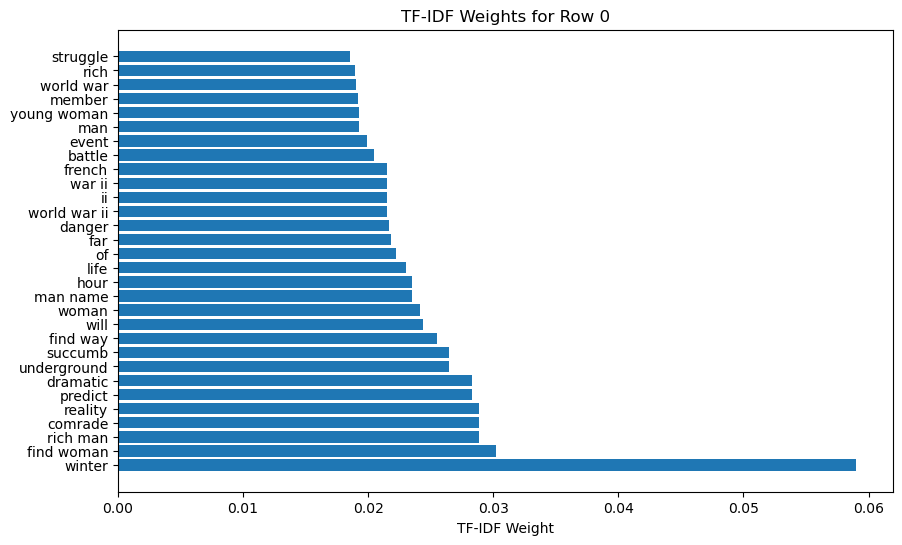

In [162]:
plot_tf_weights(dtm_idf, tf_feature_names, 0)

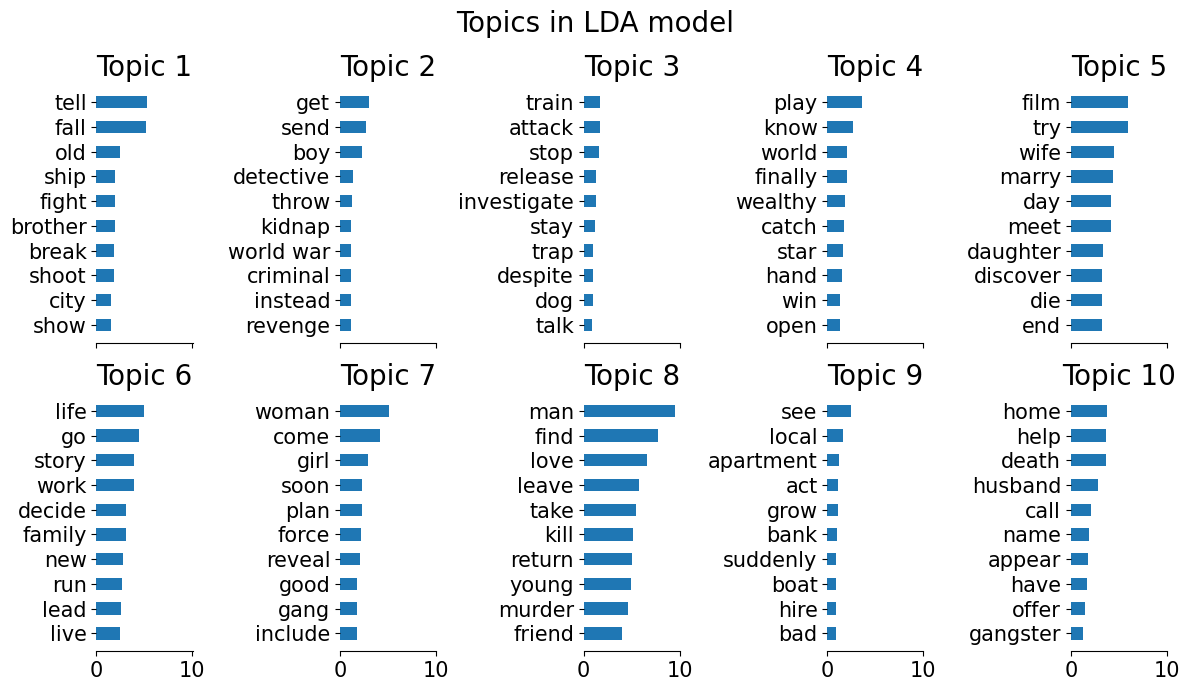

In [164]:
# General parameters to adapt
n_topics = 10
n_top_words = 10
alpha = 0.4
# doc_topic_prior:=alpha : represents the parameter of the Dirichlet prior on the per-document topic distributions. It influences how many topics are likely to be present in a document.
    # Higher alpha values result in documents with more topics, while lower values lead to sparser documents with fewer dominant topics.
beta = 0.1
# topic_word_prior := beta : represents the parameter of the Dirichlet prior on the per-topic word distributions. It controls the number of words associated with each topic.
#Similar to alpha, higher beta values result in topics with more words, while lower values lead to sparser topics.


# Create the LatentDirichletAllocation model
lda = LatentDirichletAllocation(n_components=n_topics,
                                doc_topic_prior= alpha,
                                topic_word_prior= beta,
                                learning_method='batch',
                                max_iter=50,
                                random_state=7, n_jobs=-1, verbose=0)

#lda.fit(dtm)
lda.fit(dtm)

# Plot the top n words for all topics

plot_top_words(lda, tf_feature_names, n_top_words=10, n_topics=n_topics, title="Topics in LDA model")

In [17]:
from gensim.corpora.dictionary import Dictionary
from gensim.models.coherencemodel import CoherenceModel

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda, n_words=n_top_words)

dictionary = Dictionary(docs)
bow_corpus = [dictionary.doc2bow(topic_words) for topic_words in topic_keywords]

cm = CoherenceModel(topics=topic_keywords, corpus=bow_corpus, dictionary=dictionary, coherence='u_mass')
coherence = cm.get_coherence_per_topic()
coherence

[8.000045070811953e-12,
 8.000045070811953e-12,
 8.000045070811953e-12,
 8.000045070811953e-12,
 8.000045070811953e-12,
 8.000045070811953e-12,
 8.000045070811953e-12,
 8.000045070811953e-12]

In [292]:
lda = LatentDirichletAllocation(n_components=n_topics, learning_method='batch', max_iter=15, random_state=7)

# Define the parameter grid
param_grid = {
    'doc_topic_prior': [ 0.2, 0.4, 0.5, 0.6],
    'topic_word_prior': [0.05, 0.1, 0.15, 0.2, 0.25]
}

# Create GridSearchCV
grid_search = GridSearchCV(lda, param_grid=param_grid, cv=5, verbose=4, n_jobs=-1)

# Fit the model with the data
grid_search.fit(dtm)

# Print the best parameters
print("Best Parameters: ", grid_search.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters:  {'doc_topic_prior': 0.6, 'topic_word_prior': 0.25}


,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,man,play,send,fall,end,couple,die,secret,mother,wife
Topic 1,home,work,plot,escape,wife,people,murder,marry,plan,commit
Topic 2,scientist,group,know,meet,car,force,turn,crew,human,include
Topic 3,love,leave,money,tell,live,boy,murder,death,try,help
Topic 4,kill,woman,father,set,involve,friend,girl,begin,alien,monster
Topic 5,family,come,attempt,young,order,hand,husband,sister,criminal,mysterious
Topic 6,life,new,night,son,american,run,school,shoot,affair,appear
Topic 7,film,return,child,lead,town,agent,city,discover,follow,use


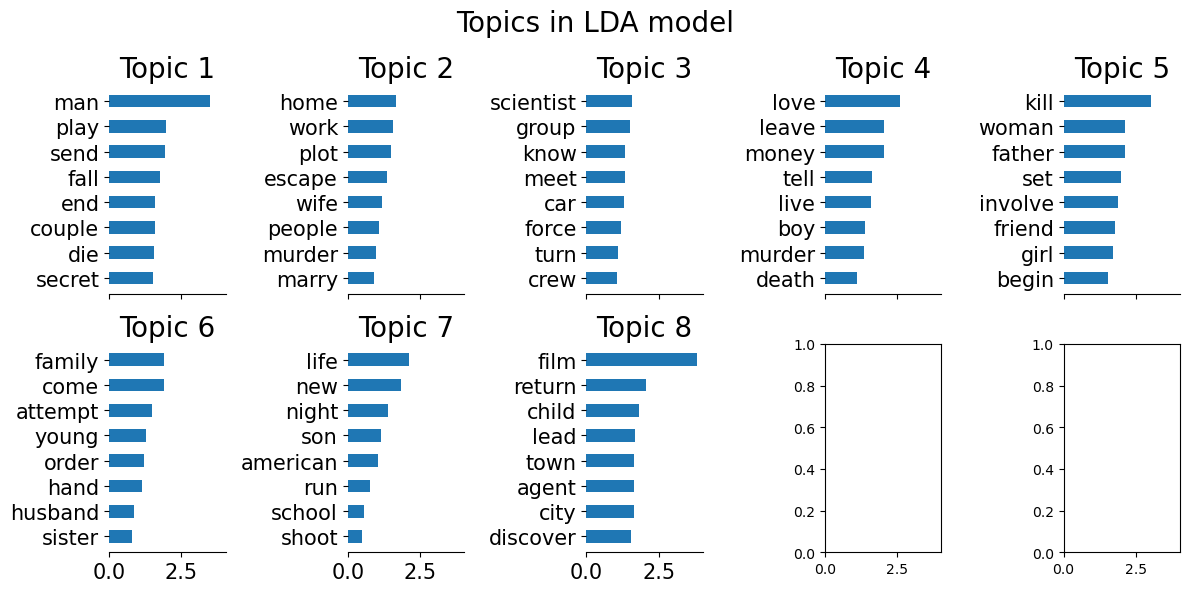

In [293]:
# Access the best model
best_lda_model = grid_search.best_estimator_

# Show the topics with their n_top words in a DataFrame form
topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=n_top_words)
df_topic_keywords = pd.DataFrame(topic_keywords)

# Improve comprehension with adapted column and index names
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
display(df_topic_keywords)

# Plot the top n words for all topics
tf_feature_names = vectorizer.get_feature_names_out()
plot_top_words(best_lda_model, tf_feature_names, 8, n_topics=df_topic_keywords.shape[0], title="Topics in LDA model")

# takes around 1min30 with 2000 features

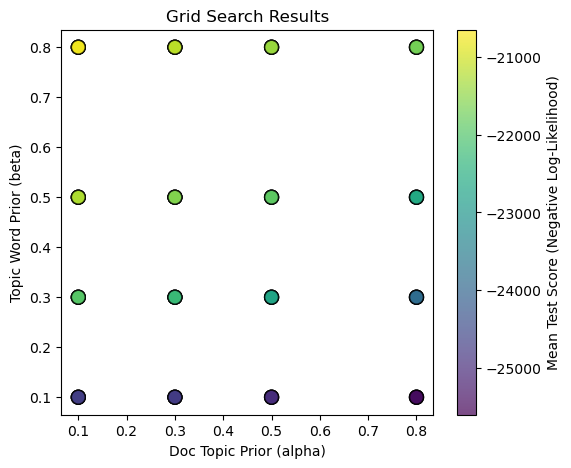

In [227]:
plot_grid_search_score(grid_search)

### With coherence as scorer (DOESNT WORK YET)

In [364]:
# Create a Gensim Dictionary for coherence computation
corpus = [vectorizer.get_feature_names_out() for _ in range(dtm.shape[0])]
# Assuming 'dictionary' is a Gensim Dictionary object
dictionary = Dictionary(corpus)

# Function to compute coherence score
def coherence_score(lda_model, X, dictionary):
    topics_words = [[dictionary[word_id] for (word_id, _) in lda_model.show_topic(topic_id, topn=10)] for topic_id in range(lda_model.n_components)]
    cm = CoherenceModel(topics=topics_words, dictionary=dictionary, coherence='u_mass')
    return cm.get_coherence()

# Create GridSearchCV with custom scoring function
grid_search = GridSearchCV(lda, param_grid=param_grid, cv=4, scoring=coherence_score, verbose=1, n_jobs=-1)

# Fit the model with the data
grid_search.fit(dtm)

# Print the best parameters
print("Best Parameters: ", grid_search.best_params_)

# Access the best model
best_lda_model = grid_search.best_estimator_

# Show the topics with their n_top words in a DataFrame form
topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=n_top_words)
df_topic_keywords = pd.DataFrame(topic_keywords)

# Improve comprehension with adapted column and index names
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
display(df_topic_keywords)

# Plot the top n words for all topics
tf_feature_names = vectorizer.get_feature_names_out()
plot_top_words(best_lda_model, tf_feature_names, 8, n_topics=df_topic_keywords.shape[0], title="Topics in LDA model")


## iii) Topics over Time

In [64]:
for period, subset in df_fictional_summaries_all.groupby('period'):
    # Perform analysis on each subset
    print(f"Analyzing data for period: {period}")
    
    vectorizer = CountVectorizer(max_df=0.75, min_df=5)
    #vectorizer = TfidfVectorizer(stop_words='english', max_df=0.75, min_df=10, max_features=n_features, ngram_range=(1, 2), norm='l1')

    dtm = vectorizer.fit_transform(subset['preprocessed_summary'])
    print(dtm.shape)

Analyzing data for period:  after 2010s
(587, 2485)
Analyzing data for period: 2000-2005
(1409, 4706)
Analyzing data for period: 2005-2010
(1982, 5562)
Analyzing data for period: 50s
(582, 2381)
Analyzing data for period: 60s
(676, 2717)
Analyzing data for period: 70s
(836, 3347)
Analyzing data for period: 80s
(1381, 4709)
Analyzing data for period: 90s
(1845, 5492)
Analyzing data for period: before 1950
(1098, 3189)


Analyzing data for period: before 1950
(1098, 1844)


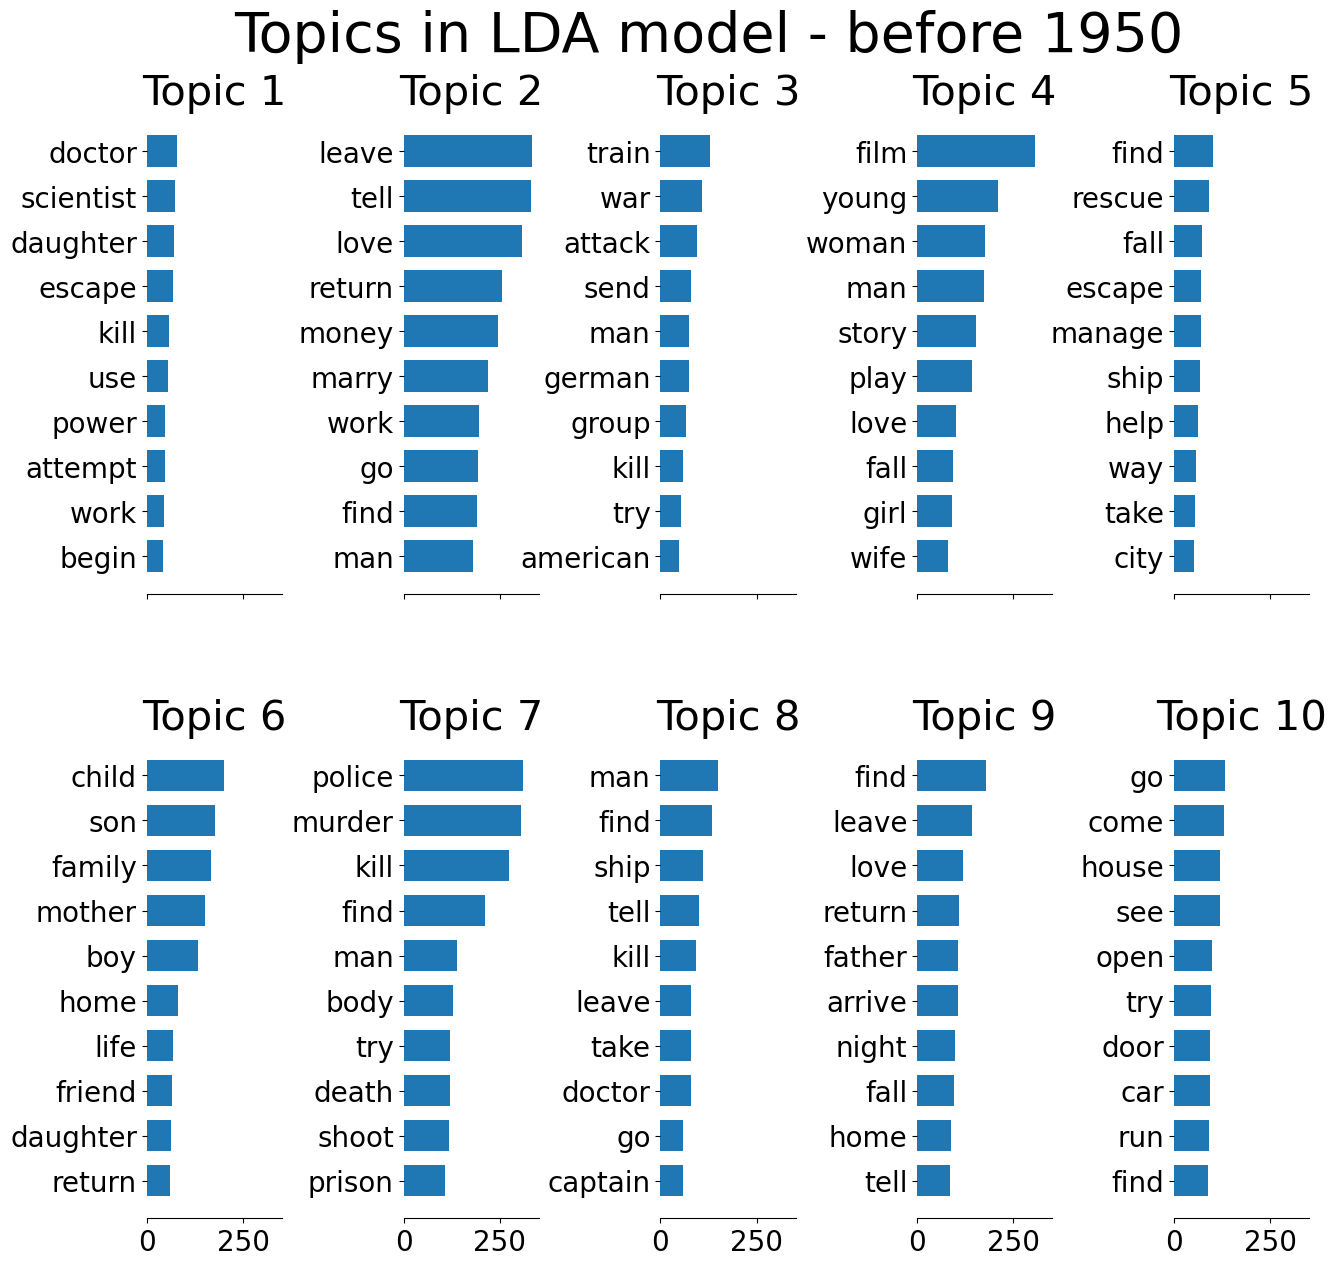

................................................................
Analyzing data for period: 50s
(582, 1284)


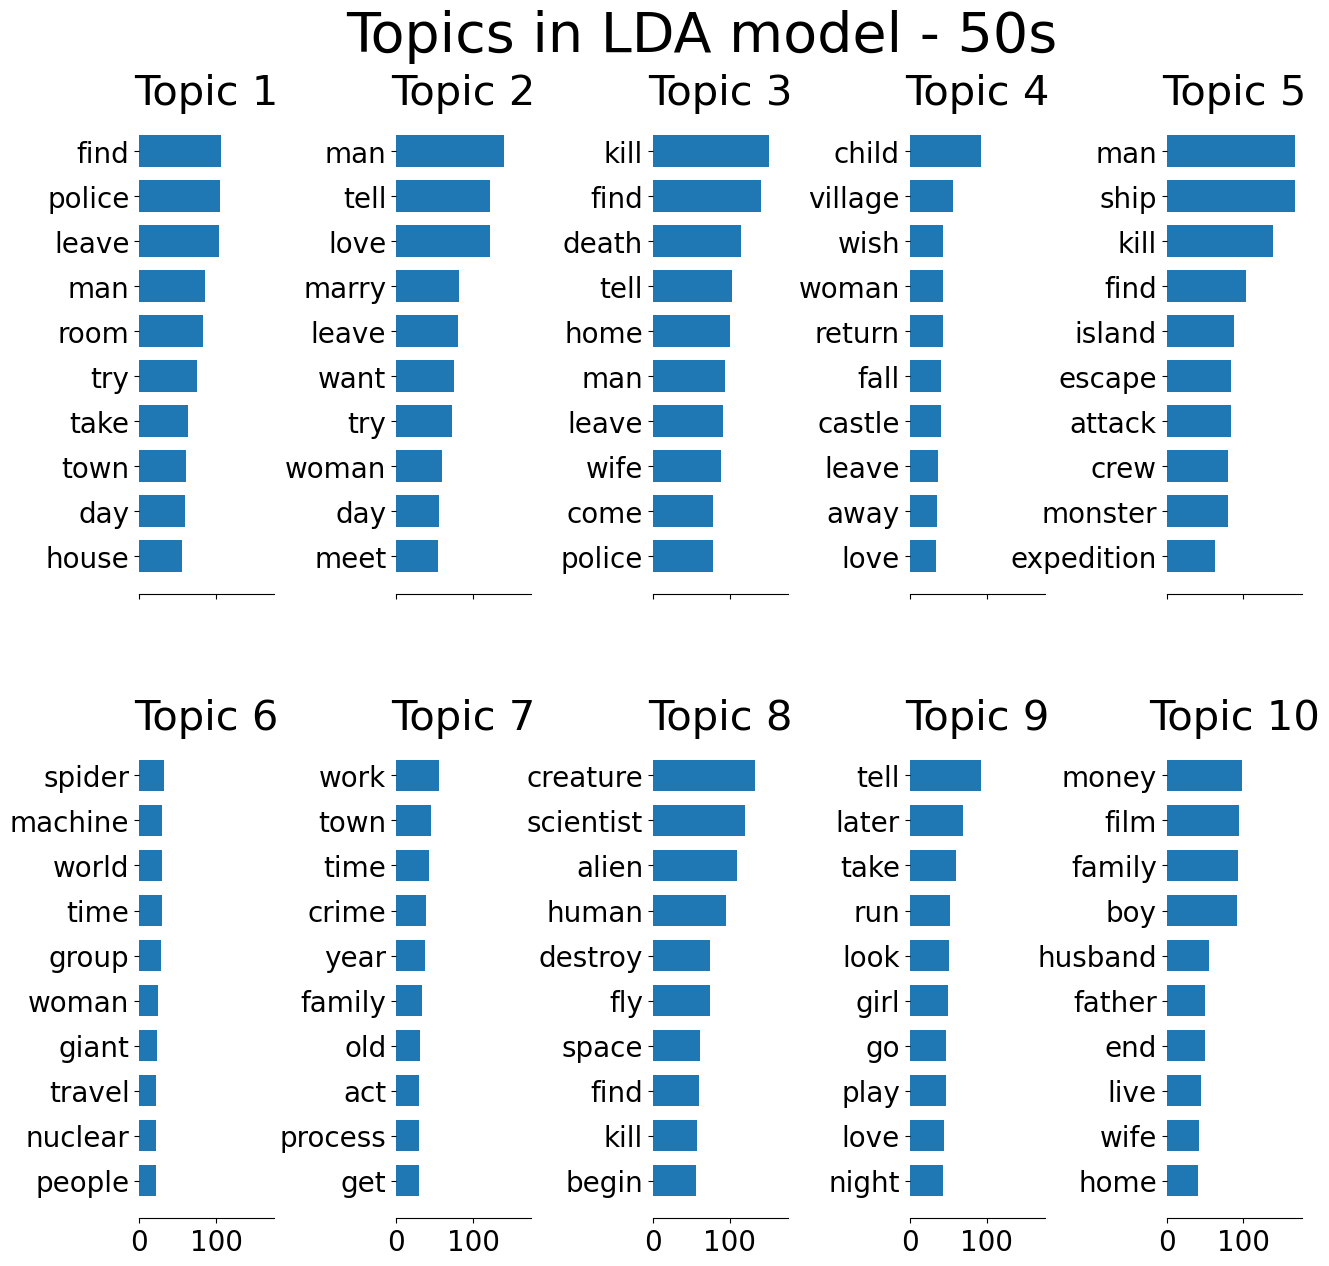

................................................................
Analyzing data for period: 60s
(676, 1506)


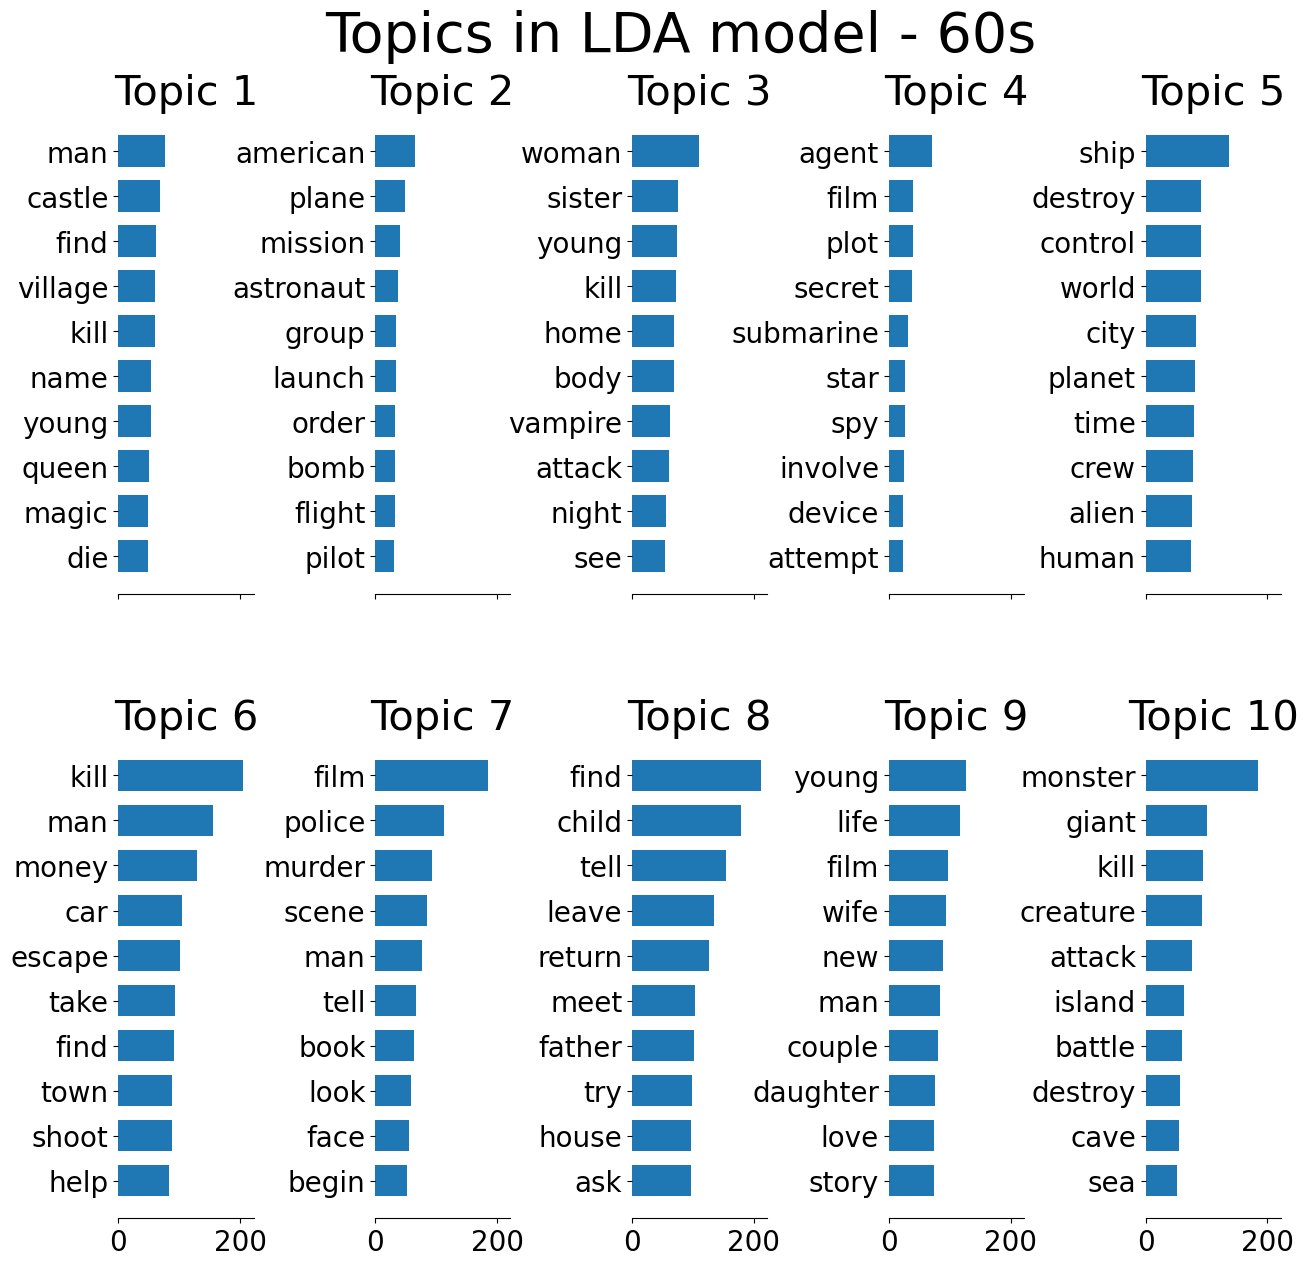

................................................................
Analyzing data for period: 70s
(836, 1878)


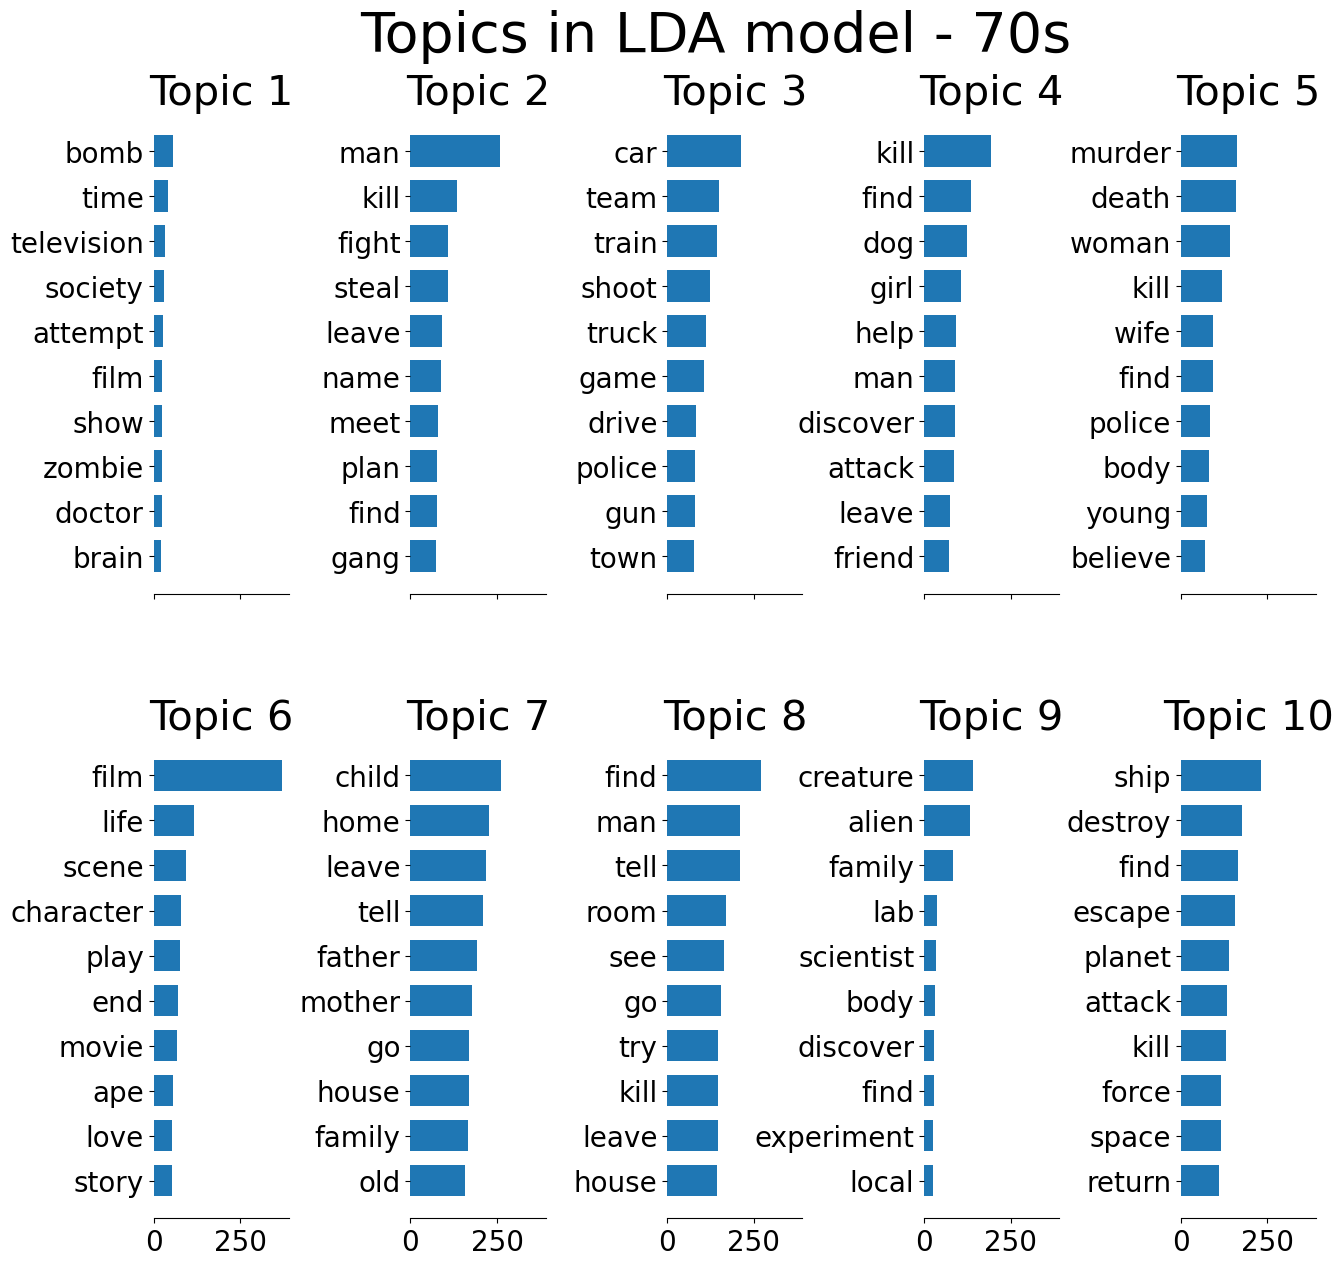

................................................................
Analyzing data for period: 80s
(1381, 2500)


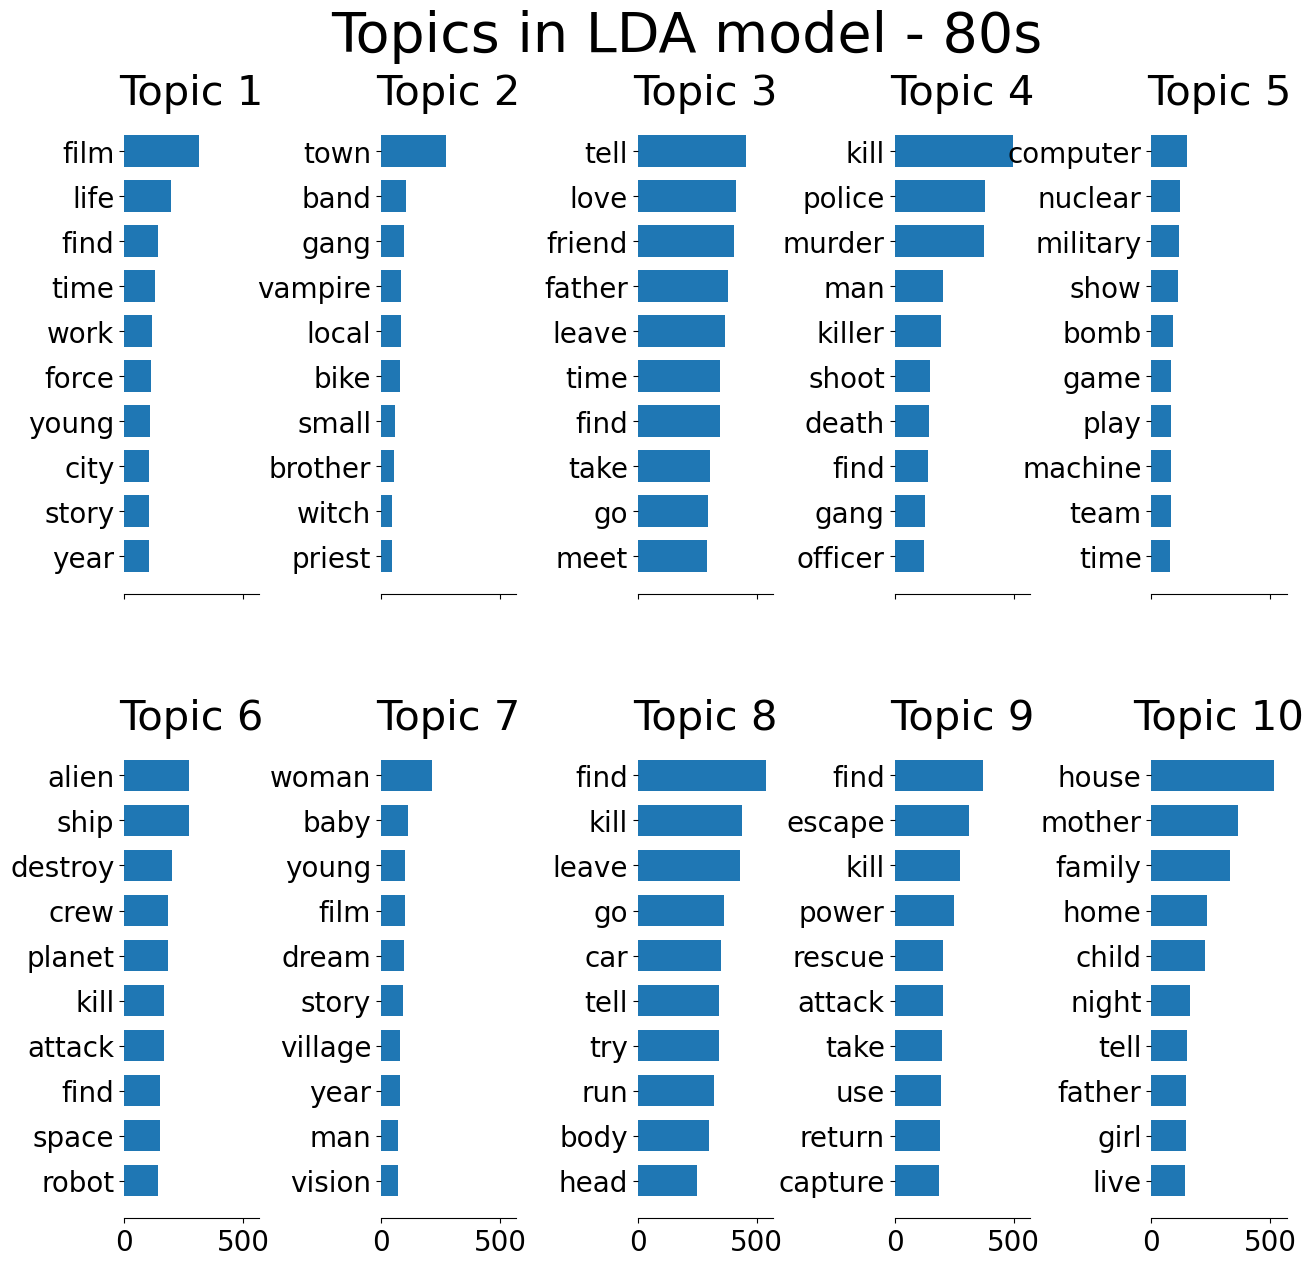

................................................................
Analyzing data for period: 90s
(1845, 2500)


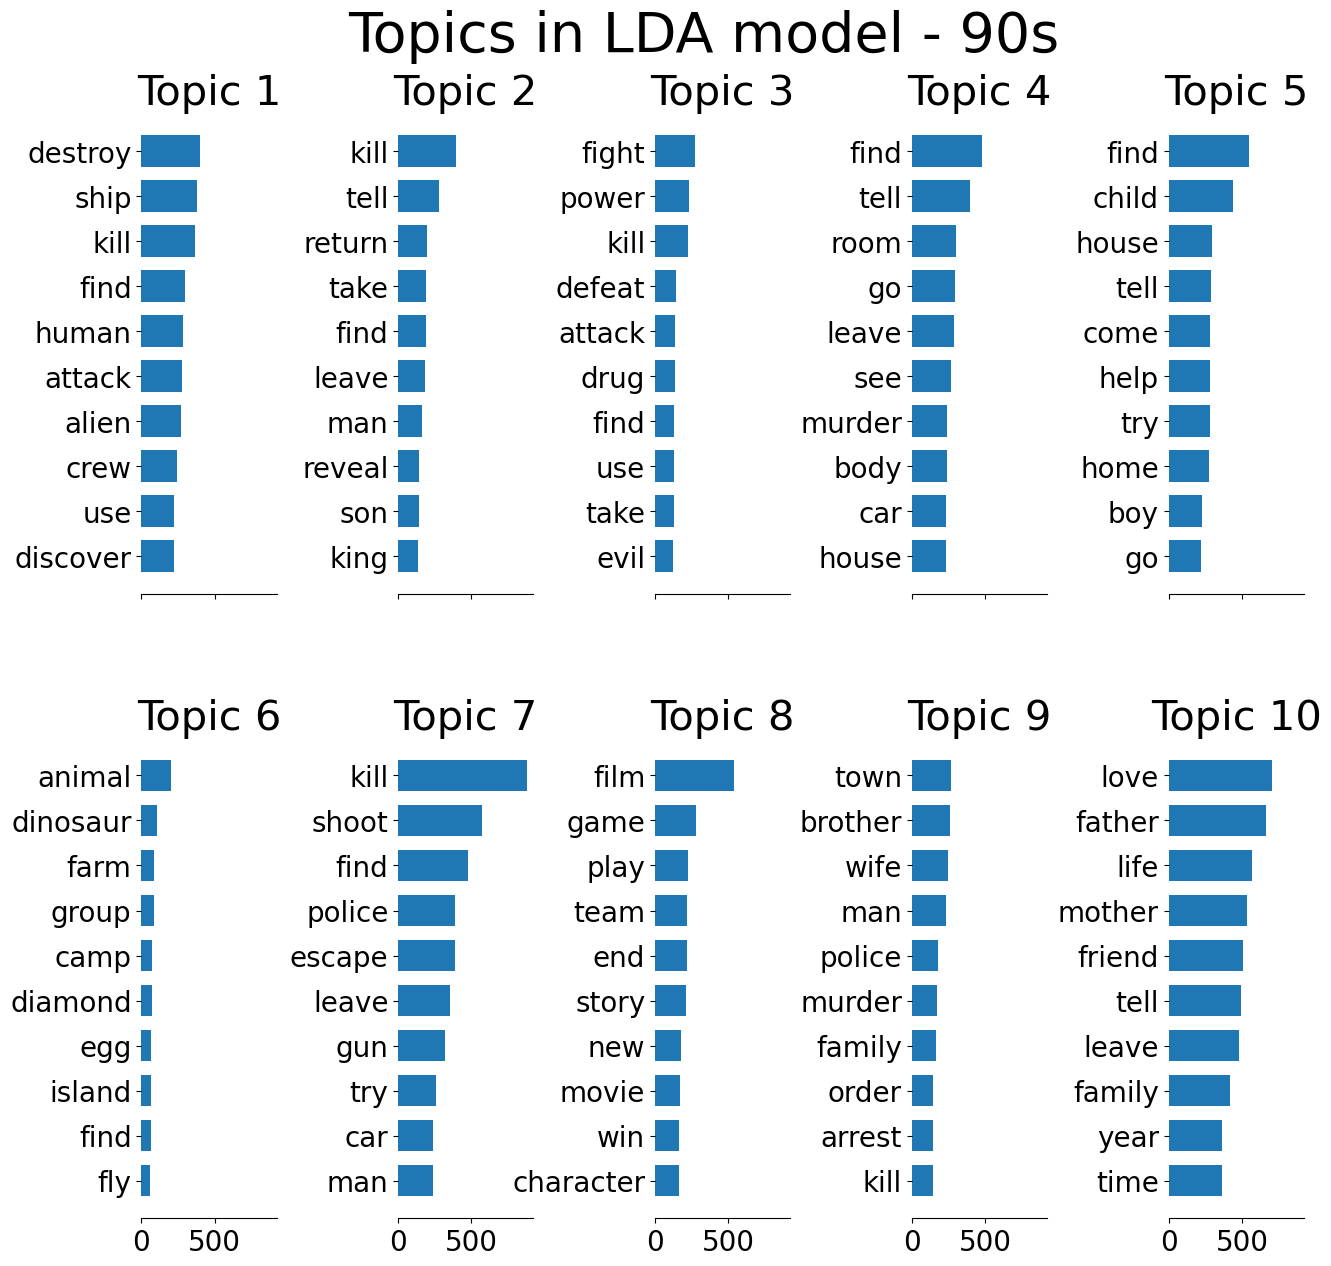

................................................................
Analyzing data for period: 2000-2005
(1409, 2500)


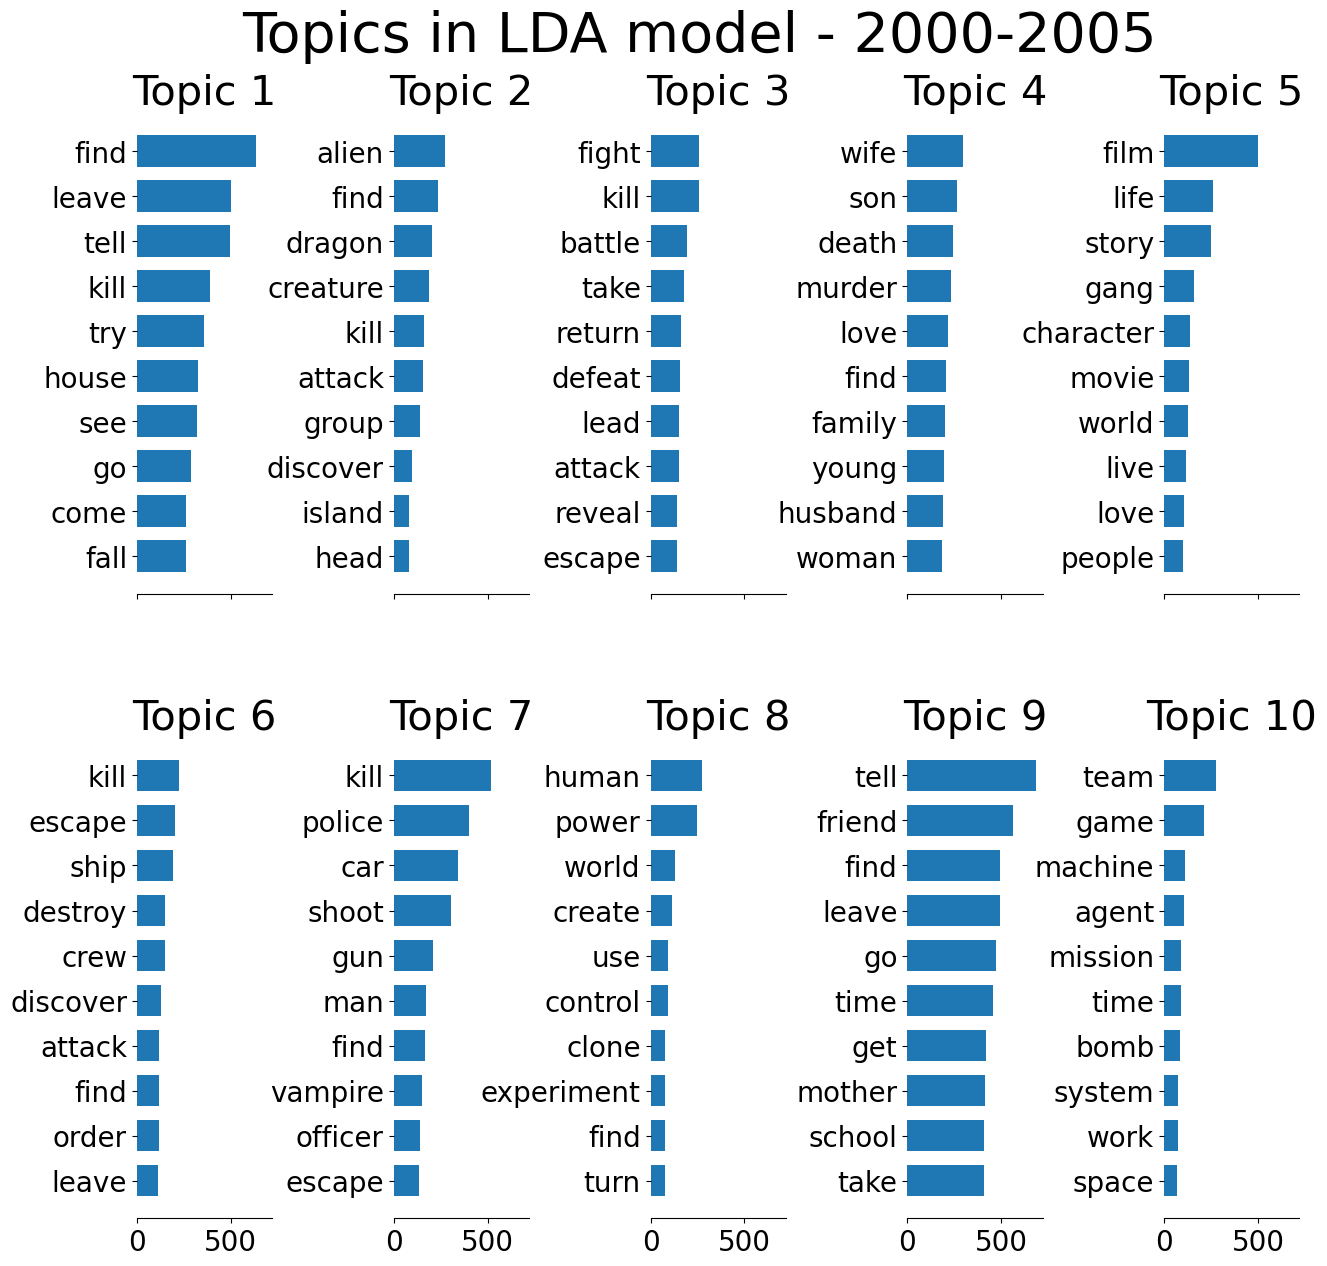

................................................................
Analyzing data for period: 2005-2010
(1982, 2500)


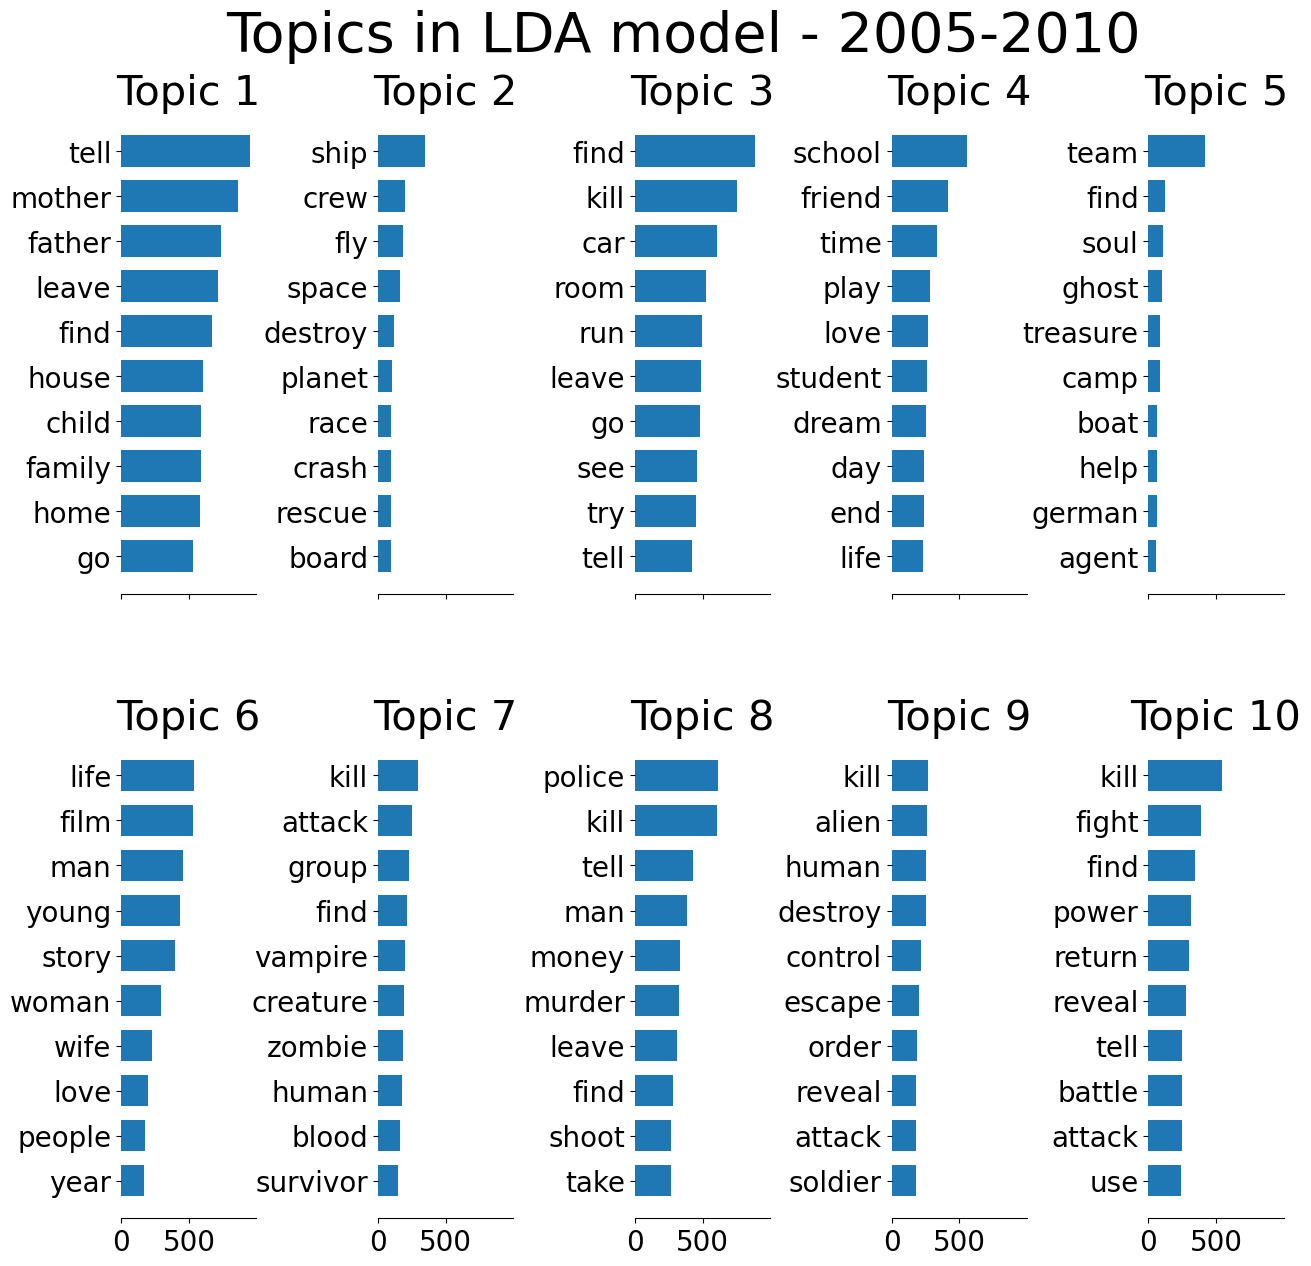

................................................................
Analyzing data for period:  after 2010s
(587, 1348)


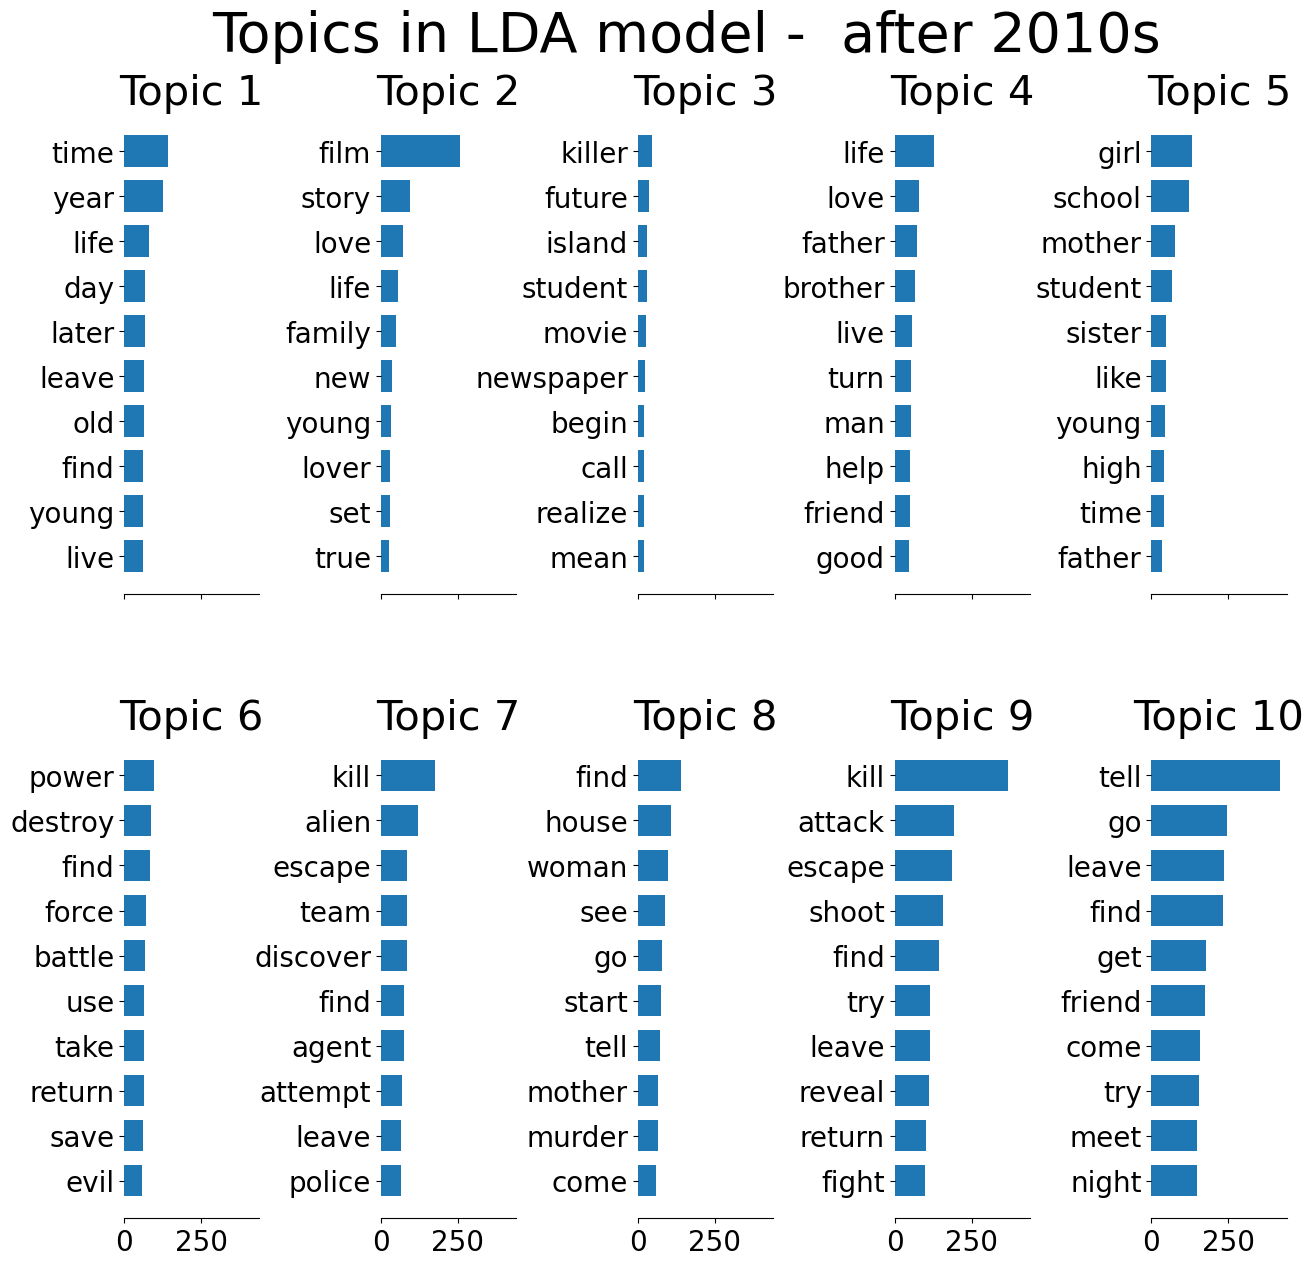

................................................................


In [123]:
# General parameters to adapt
n_topics = 10
n_features = 2500

n_top_words = 10

alpha = 0.4
# doc_topic_prior:=alpha : represents the parameter of the Dirichlet prior on the per-document topic distributions. It influences how many topics are likely to be present in a document.
    # Higher alpha values result in documents with more topics, while lower values lead to sparser documents with fewer dominant topics.
beta = 0.1
# topic_word_prior := beta : represents the parameter of the Dirichlet prior on the per-topic word distributions. It controls the number of words associated with each topic.
#Similar to alpha, higher beta values result in topics with more words, while lower values lead to sparser topics.


for period, subset in df_fictional_summaries_all.groupby('period'):
    # Perform analysis on each subset
    print(f"Analyzing data for period: {period}")
    
    vectorizer = CountVectorizer(max_df=0.75, min_df=10, max_features=n_features)
    #vectorizer = TfidfVectorizer(stop_words='english', max_df=0.75, min_df=10, max_features=n_features, ngram_range=(1, 2), norm='l1')

    dtm = vectorizer.fit_transform(subset['preprocessed_summary'])
    print(dtm.shape)

    # normalize per row
    #transformer = Normalizer(norm='l1').fit(dtm)
    #dtm = transformer.transform(dtm)
    
    # Create the LatentDirichletAllocation model
    lda = LatentDirichletAllocation(
        n_components=n_topics,
        doc_topic_prior= alpha, 
        topic_word_prior= beta,
        max_iter=20,
        random_state=7,
        verbose=0,
        batch_size=128,
        n_jobs = -1,
    )

    lda.fit(dtm)
    #lda.fit(dtm_normalized)

    # Plot the top n words for all topics
    tf_feature_names = vectorizer.get_feature_names_out()
    plot_top_words(lda, tf_feature_names, n_top_words=n_top_words, n_topics=n_topics, title=f"Topics in LDA model - {period}")
    print("................................................................")

In [82]:
#grouped_genre_movies_df=grouped_genre_movies.to_frame().rename(columns={'release_year':'count'}).reset_index()


#count the number of fictional movies for each period of n years
def period(n,df):
    df_up = df.groupby('release_year')['release_year'].count()
    df_up = df_up.to_frame().rename(columns={'release_year':'count'}).reset_index()
    df_up = df_up.groupby(df_up["release_year"]//n).sum()
    df_up['release_year']=df_up.index*n
    df_up = df_up.reset_index(drop=True)
    return df_up
    
#period(10,grouped_genre_movies_df)

#Merge preprocessed summary with another dataframe than contains dates

#Script that group preprocessed summary per decade
#Run LDA for each decade
#try to match topics
#Cosine distance to evaluate how much topics have changed

#Find others fictionnal genres 
#look at intersection between crime fiction and sf/fantaisy

#Use topic modelling to define topics with n keywords. Then, look for trends on all the summaries 

In [83]:
period(10,df_fictional_summaries_all)

,release_year,count
0,1890.0,4
1,1900.0,10
2,1910.0,59
3,1920.0,183
4,1930.0,367
5,1940.0,428
6,1950.0,573
7,1960.0,662
8,1970.0,794
9,1980.0,1340


In [82]:
df_fictional_summaries_all["release_decade"]= df_fictional_summaries_all["release_year"].map(lambda x:(x//10)*10)
df_fictional_summaries_all

,Wikipedia_movie_ID,movie_summary,movie_name,movie_release_date,movie_box_office_revenu,movie_runtime,release_year,preprocessed_summary,wordcount_min10freq,period,release_decade
0,31186339,The nation of Panem consists of a wealthy Capi...,The Hunger Games,2012-03-12,686533290.0,142.0,2012.0,nation consist wealthy poor district punishmen...,297,2010s,2010.0
1,1838882,"The evil Lord Conqueror, head of Conqueror's C...",The Storm Riders,1998,NaN,130.0,1998.0,evil head give prophecy say find young child g...,117,90s,1990.0
2,4466226,During the Great depression in 1933 in Winnipe...,The Saddest Music in the World,2003-09-07,NaN,100.0,2003.0,great depression old fortune teller predict fu...,256,2000-2005,2000.0
3,657446,"In Los Angeles, California Fletcher Reede is ...",Liar Liar,1997-03-21,302710615.0,86.0,1997.0,career focus lawyer divorced father love spend...,245,90s,1990.0
4,32163620,"In the winter of 1945, immediately after the l...",Gates of the Night,1946-12-03,NaN,120.0,1946.0,winter immediately liberation member french un...,45,before 1950,1940.0
...,...,...,...,...,...,...,...,...,...,...,...
9551,24211707,The film follows a United States Border Patrol...,Borderline,1980-10-31,NaN,99.0,1980.0,film follow force track killer young mexican b...,582,70s,1980.0
9555,13348400,Jennie Lee is the lead singer of an all-girl ...,Satisfaction,1988-02-12,8253123.0,92.0,1988.0,lead singer girl rock band name high school gr...,285,80s,1980.0
9556,277160,"Virginia ""Gin"" Baker is an investigator for W...",Entrapment,1999-04-30,212404396.0,113.0,1999.0,investigator international art thief priceless...,162,90s,1990.0
9558,17736697,Paula Eastman is a Hollywood actress with an ...,Torch Song,1993-05-23,NaN,89.0,1993.0,actress alcohol problem career poorly sleep ac...,54,90s,1990.0
